<center><h1>Model v1 - baseline</h1></center>

Kaggle Competition for Music Recommendation. Do Sample Matrix Factorization. Results in socre 0.54166.

<hr>

## Table of Contents
1. [Environment Setting](#1)
    1. [Import Library](#1.1)
    2. [Load Dataset](#1.2)
2. [Data Modeling](#2)
    1. [Split Train and Validation Dataset](#2.1)
    2. [Dataframe to Sparce Matrix](#2.2)
    3. [Matrix Factorization: Truncated SVD](#2.3)
    4. [Prediction(Recommendation)](#2.4)
3. [Submission](#3)
    1. [Make Full Train Dataset](#3.1)
    2. [Modeling using Full Train Dataset](#3.2)
    3. [Make Prediction for Submission](#3.3)

<hr>

## Environment Setting <a id="1"></a>

### Import Library <a id="1.1"></a>

In [1]:
# Dataframe
import pandas as pd

# Numerical Data
import numpy as np

# Matrix Factorization: SVD
from sklearn.decomposition import TruncatedSVD

# Sparse Matrix
from scipy.sparse import csr_matrix

# FOR Loop Visualization(verbose)
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

In [2]:
pd.options.display.max_rows = 499
pd.options.display.max_columns = 499
pd.options.mode.chained_assignment = None

In [3]:
fname = '../static/fonts/D2Coding.ttc'
ffamily = fm.FontProperties(fname=fname).get_name()
plt.rcParams['font.family'] = ffamily
plt.rcParams['font.size'] = 14

In [4]:
%matplotlib inline

### Load Dataset <a id="1.2"></a>

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [6]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [7]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [8]:
sample_submission.head()

,id,target
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


<hr>

## Data Modeling <a id="2"></a>

### Split Train and Validation Dataset <a id="2.1"></a>

In [9]:
train.shape

(7377418, 6)

In [10]:
validation = train.sample(frac=0.1, random_state=2020, )
train = train.drop(validation.index)

In [11]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)

In [12]:
train.shape

(6639676, 6)

In [13]:
validation.shape

(737742, 6)

### Dataframe to Sparce Matrix <a id="2.2"></a>

In [14]:
msno = train.msno.unique()
song_id = train.song_id.unique()

In [15]:
len(msno)

30640

In [16]:
len(song_id)

342679

In [17]:
msno2idx = {m:idx for idx, m in enumerate(msno)}
song2idx = {s:idx for idx, s in enumerate(song_id)}

In [18]:
users = train.msno.apply(lambda x: msno2idx[x])
users = np.array(users)
users[:10]

array([0, 1, 1, 0, 1, 0, 2, 2, 2, 3])

In [19]:
items = train.song_id.apply(lambda x: song2idx[x])
items = np.array(items)
items[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
data = train.target
data = np.array(data)
data[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [21]:
train.head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1
4,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1
6,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1
7,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,t0aT90DlS1TGncgnKoL0SvfAWEr3Dl72QBVcokmKfLc=,my library,Local playlist more,local-library,1
9,TJU0Gfvy7FB+r89bWovPKXTjuApTCiv3xg/tt5shR78=,u6/Pb7X4u7KU4gXrBgGqt8RlRrNNFLn03tLAHyxRxwA=,my library,NaN,top-hits-for-artist,0


In [22]:
train_csr = csr_matrix((data, (users, items)))

In [23]:
train_csr

<30640x342679 sparse matrix of type '<class 'numpy.longlong'>'
	with 6639676 stored elements in Compressed Sparse Row format>

### Matrix Factorization: Truncated SVD <a id="2.3"></a>

In [24]:
svd = TruncatedSVD(n_components=100, n_iter=5, random_state=2020)
U = svd.fit_transform(train_csr)
S = np.diag(svd.singular_values_)
Vt = svd.components_.T

In [25]:
U.shape

(30640, 100)

In [26]:
S.shape

(100, 100)

In [27]:
Vt.shape

(342679, 100)

### Prediction(Recommendation) <a id="2.4"></a>

In [28]:
def item_to_idx(item, item_dict):
    if item in item_dict:
        return item_dict[item]
    else:
        return -1

In [29]:
users = np.array(validation.msno.apply(lambda x: item_to_idx(x, msno2idx)))

In [30]:
items = np.array(validation.song_id.apply(lambda x: item_to_idx(x, song2idx)))

In [31]:
real = np.array(validation.target)

In [32]:
validation.head(1)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,QTwsBNF1Ie0JhgQ5i27OOyen2u+0K3j9cR7l0ZZeAbY=,iilqYfHUSf7ETyPvZwZoWBojhFcuOWynMeQoPBnj0/k=,discover,Online playlist more,online-playlist,1


In [33]:
assert users[0] == msno2idx['QTwsBNF1Ie0JhgQ5i27OOyen2u+0K3j9cR7l0ZZeAbY=']

In [34]:
assert items[0] == song2idx['iilqYfHUSf7ETyPvZwZoWBojhFcuOWynMeQoPBnj0/k=']

In [35]:
assert real[0] == 1

In [36]:
def predict(user, item, threshold):
    rating = user @ item
    return rating, int(rating >= threshold)

In [37]:
def calculate_accuracy(prediction, real):
    return np.mean(np.equal(prediction, real))

In [38]:
scores = dict()
thresholds = np.linspace(0, 1, num=11)
for threshold in tqdm(thresholds):
    prediction = list()
    for user, item in zip(users, items):
        _, p = predict(U[user], Vt[item], threshold)
        prediction.append(p)
    prediction = np.array(prediction)

    accuracy = calculate_accuracy(prediction, real)
    scores[threshold] = accuracy

100%|██████████| 11/11 [00:25<00:00,  2.33s/it]


In [39]:
scores

{0.0: 0.5481428466862399,
 0.1: 0.6238441081028328,
 0.2: 0.6047642671828363,
 0.30000000000000004: 0.5845037967202626,
 0.4: 0.5651121936937303,
 0.5: 0.5473742853192579,
 0.6000000000000001: 0.5317753360931057,
 0.7000000000000001: 0.5188358531844466,
 0.8: 0.5091576730076368,
 0.9: 0.5030213814585587,
 1.0: 0.49974923482735156}

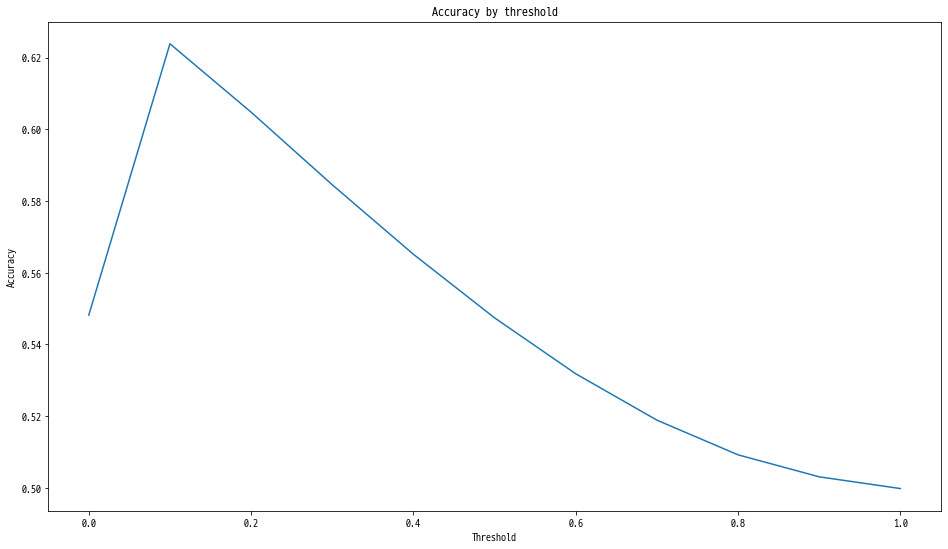

In [40]:
plt.figure(figsize=(16, 9))
plt.plot(list(scores.keys()), list(scores.values()))
plt.title('Accuracy by threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

## Submission <a id="3"></a>

### Make Full Train Dataset <a id="3.1"></a>

In [41]:
train = pd.concat([train, validation], ignore_index=True, axis=0).reset_index(drop=True)
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1
4,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1


In [42]:
train.shape

(7377418, 6)

### Modeling using Full Train Dataset <a id="3.2"></a>

In [43]:
msno = train.msno.unique()
song_id = train.song_id.unique()

In [44]:
msno2idx = {m: idx for idx, m in enumerate(msno)}
song2idx = {s: idx for idx, s in enumerate(song_id)}

In [45]:
users = np.array(train.msno.apply(lambda x: msno2idx[x]))
items = np.array(train.song_id.apply(lambda x: song2idx[x]))
data = np.array(train.target)

In [46]:
train_csr = csr_matrix((data, (users, items)))

In [47]:
train_csr

<30755x359966 sparse matrix of type '<class 'numpy.longlong'>'
	with 7377418 stored elements in Compressed Sparse Row format>

In [48]:
svd = TruncatedSVD(n_components=100, n_iter=5, random_state=2020)
U = svd.fit_transform(train_csr)
S = np.diag(svd.singular_values_)
Vt = svd.components_.T

### Make Prediction for Submission <a id="3.3"></a>

In [49]:
users = test.msno.apply(lambda x: item_to_idx(x, msno2idx))
items = test.song_id.apply(lambda x: item_to_idx(x, song2idx))

In [50]:
prediction = list()
for user, item in tqdm(zip(users, items)):
    _, p = predict(U[user], Vt[item], 0.1)
    prediction.append(p)

2556790it [00:08, 295474.99it/s]


In [51]:
sample_submission['target'] = prediction
sample_submission

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2556785,2556785,0
2556786,2556786,0
2556787,2556787,0
2556788,2556788,0


In [52]:
sample_submission.to_csv('../data/submissions/model_v1.csv', index=False)